# Feature Engineering for Credit Risk

**Short Description**: Builds features to predict credit risk using customer transaction patterns. Prepares data for modeling by creating and saving customer-level features.

This notebook creates features for the credit risk model using the Xente dataset. It builds Recency, Frequency, Monetary (RFM) features, adds behavioral features, handles outliers, and uses Weight of Evidence (WoE) and Information Value (IV) to check feature importance. Features are saved to `data/processed/customer_features.csv` for Task 4.


## 1. Set Up Libraries and Load Data

**Short Description**: Sets up tools and loads transaction data. Ensures the environment is ready for feature creation.

Install tools and load libraries for data work and WoE/IV analysis. Load the Xente dataset and convert `TransactionStartTime` to datetime. Create a folder to save features.


In [1]:
!pip install scipy==1.15.3 statsmodels==0.14.4 scorecardpy==0.1.9.7 sidetable==0.9.1

import  numpy as np
import pandas as pd
import sidetable
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scorecardpy as sc
import os

# Create folder for processed data
os.makedirs('../data/processed', exist_ok=True)

# Load transactions data
df = pd.read_csv('../data/raw/data.csv')
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

# Show first few rows
print('Transactions Data:')
display(df.head())



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
D:\Python_Projects\10academy\b5w5-Credit-Risk-Probability-Model-for-Alternative-Data\env\Lib\site-packages\scorecardpy\germancredit.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Transactions Data:


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15 02:18:49+00:00,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15 02:19:08+00:00,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15 02:44:21+00:00,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15 03:32:55+00:00,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15 03:34:21+00:00,2,0


## 2. Create RFM Features

**Short Description**: Creates features to track customer activity. Summarizes how recent, frequent, and valuable transactions are.

Build RFM features for each customer:
- **Recency**: Days since last transaction.
- **Frequency**: Number of transactions.
- **Monetary**: Total amount spent.
Show the RFM table and basic stats.


In [2]:
# Set reference date (day after last transaction)
reference_date = df['TransactionStartTime'].max() + pd.Timedelta(days=1)

# Calculate RFM features
rfm = df.groupby('CustomerId').agg({
    'TransactionStartTime': lambda x: (reference_date - x.max()).days,
    'TransactionId': 'count',
    'Amount': 'sum'
}).reset_index()

# Rename columns
rfm.columns = ['CustomerId', 'Recency', 'Frequency', 'Monetary']

# Show RFM table
print('RFM Features:')
display(rfm.head())

# Show stats
print('RFM Stats:')
display(rfm.describe())


RFM Features:


,CustomerId,Recency,Frequency,Monetary
0,CustomerId_1,84,1,-10000.0
1,CustomerId_10,84,1,-10000.0
2,CustomerId_1001,90,5,20000.0
3,CustomerId_1002,26,11,4225.0
4,CustomerId_1003,12,6,20000.0


RFM Stats:


,Recency,Frequency,Monetary
count,3742.000000,3742.000000,3.742000e+03
mean,31.461251,25.564404,1.717377e+05
std,27.118932,96.929602,2.717305e+06
min,1.000000,1.000000,-1.049000e+08
25%,6.000000,2.000000,4.077438e+03
50%,25.000000,7.000000,2.000000e+04
75%,54.000000,20.000000,7.996775e+04
max,91.000000,4091.000000,8.345124e+07


## 3. Add Behavioral Features

**Short Description**: Adds features to capture customer behavior. Tracks spending patterns and transaction timing.

Create extra features to capture customer behavior:
- **Average Transaction Amount**: Average spend per transaction.
- **Category Counts**: Number of transactions in `financial_services` and `airtime`.
- **Night Activity**: Share of transactions from 0–6 AM.
Merge with RFM features and fill missing values with zeros.


In [3]:
# Average transaction amount
avg_amount = df.groupby('CustomerId')['Amount'].mean().reset_index(name='AvgTransactionAmount')

# Count transactions in key categories
category_freq = df[df['ProductCategory'].isin(['financial_services', 'airtime'])].groupby(['CustomerId', 'ProductCategory'])['TransactionId'].count().unstack(fill_value=0).reset_index()
category_freq.columns = ['CustomerId', 'Freq_FinancialServices', 'Freq_Airtime']

# Night activity (0–6 AM)
df['TransactionHour'] = df['TransactionStartTime'].dt.hour
night_hours = df[df['TransactionHour'].isin(range(0, 7))].groupby('CustomerId')['TransactionId'].count().reset_index(name='NightCount')
total_transactions = df.groupby('CustomerId')['TransactionId'].count().reset_index(name='TotalTransactions')
night_activity = night_hours.merge(total_transactions, on='CustomerId')
night_activity['NightRatio'] = night_activity['NightCount'] / night_activity['TotalTransactions']

# Merge features
features = rfm.merge(avg_amount, on='CustomerId').merge(category_freq, on='CustomerId', how='left').merge(night_activity[['CustomerId', 'NightRatio']], on='CustomerId', how='left')
features.fillna({'Freq_FinancialServices': 0, 'Freq_Airtime': 0, 'NightRatio': 0}, inplace=True)

# Show combined features
print('All Features:')
display(features.head())


All Features:


,CustomerId,Recency,Frequency,Monetary,AvgTransactionAmount,Freq_FinancialServices,Freq_Airtime,NightRatio
0,CustomerId_1,84,1,-10000.0,-10000.000000,1.0,0.0,0.000000
1,CustomerId_10,84,1,-10000.0,-10000.000000,1.0,0.0,0.000000
2,CustomerId_1001,90,5,20000.0,4000.000000,2.0,3.0,0.000000
3,CustomerId_1002,26,11,4225.0,384.090909,5.0,6.0,0.181818
4,CustomerId_1003,12,6,20000.0,3333.333333,3.0,3.0,0.000000


## 4. Handle Outliers

**Short Description**: Reduces impact of extreme values. Transforms monetary features to stabilize them.

Apply log transformation to `Monetary` and `AvgTransactionAmount` to reduce the impact of extreme values (from EDA: `Amount` range -1,000,000 to 9,880,000). Shift values to be positive first. Show updated features.


In [4]:
# Log transform Monetary and AvgTransactionAmount
features['LogMonetary'] = np.log1p(features['Monetary'] - features['Monetary'].min() + 1)
features['LogAvgTransactionAmount'] = np.log1p(features['AvgTransactionAmount'] - features['AvgTransactionAmount'].min() + 1)

# Show updated features
print('Features with Log Transformation:')
display(features.head())


Features with Log Transformation:


,CustomerId,Recency,Frequency,Monetary,AvgTransactionAmount,Freq_FinancialServices,Freq_Airtime,NightRatio,LogMonetary,LogAvgTransactionAmount
0,CustomerId_1,84,1,-10000.0,-10000.000000,1.0,0.0,0.000000,18.468423,12.936039
1,CustomerId_10,84,1,-10000.0,-10000.000000,1.0,0.0,0.000000,18.468423,12.936039
2,CustomerId_1001,90,5,20000.0,4000.000000,2.0,3.0,0.000000,18.468709,12.969217
3,CustomerId_1002,26,11,4225.0,384.090909,5.0,6.0,0.181818,18.468558,12.960752
4,CustomerId_1003,12,6,20000.0,3333.333333,3.0,3.0,0.000000,18.468709,12.967662


## 5. Calculate WoE and IV

**Short Description**: Checks feature importance for risk prediction. Uses `FraudResult` to rank features.

Use `FraudResult` as a temporary target to calculate WoE and IV for features (`Recency`, `Frequency`, `LogMonetary`, `LogAvgTransactionAmount`, `NightRatio`, `Freq_FinancialServices`, `Freq_Airtime`). Plot WoE trends and show IV scores to rank feature importance.


FraudResult in features: True
Sample features with FraudResult:


,CustomerId,FraudResult
0,CustomerId_1,0
1,CustomerId_10,0
2,CustomerId_1001,0
3,CustomerId_1002,0
4,CustomerId_1003,0


Feature dtypes:


Recency                    float64
Frequency                  float64
LogMonetary                float64
LogAvgTransactionAmount    float64
NightRatio                 float64
Freq_FinancialServices     float64
Freq_Airtime               float64
dtype: object

Sample feature values:


,Recency,Frequency,LogMonetary,LogAvgTransactionAmount,NightRatio,Freq_FinancialServices,Freq_Airtime
0,84.0,1.0,18.468423,12.936039,0.000000,1.0,0.0
1,84.0,1.0,18.468423,12.936039,0.000000,1.0,0.0
2,90.0,5.0,18.468709,12.969217,0.000000,2.0,3.0
3,26.0,11.0,18.468558,12.960752,0.181818,5.0,6.0
4,12.0,6.0,18.468709,12.967662,0.000000,3.0,3.0


[INFO] creating woe binning ...


D:\Python_Projects\10academy\b5w5-Credit-Risk-Probability-Model-for-Alternative-Data\env\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
D:\Python_Projects\10academy\b5w5-Credit-Risk-Probability-Model-for-Alternative-Data\env\Lib\site-packages\scorecardpy\condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
D:\Python_Projects\10academy\b5w5-Credit-Risk-Probability-Model-for-A

Bins DataFrame dtypes:
Recency dtypes:


D:\Python_Projects\10academy\b5w5-Credit-Risk-Probability-Model-for-Alternative-Data\env\Lib\site-packages\scorecardpy\woebin.py:594: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).groupby('brkp').apply(lambda x: sum(x.ae)).reset_index(name='chisq')
D:\Python_Projects\10academy\b5w5-Credit-Risk-Probability-Model-for-Alternative-Data\env\Lib\site-packages\scorecardpy\woebin.py:640: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  binning_chisq = binning_chisq.groupby('brkp', group_keys=False).agg({
D:\Python_Projects\10a

variable              object
bin                   object
count                  int64
count_distr          float64
good                   int64
bad                    int64
badprob              float64
woe                  float64
bin_iv               float64
total_iv             float64
breaks                object
is_special_values       bool
dtype: object

Recency sample:


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,[[[[array([array([array([array([array([array([...,"[-inf,4.0)",586,0.156601,574,12,0.020478,0.356133,0.023712,0.28367,4.0,False
1,[[[[array([array([array([array([array([array([...,"[4.0,8.0)",493,0.131748,491,2,0.004057,-1.279441,0.122951,0.28367,8.0,False
2,[[[[array([array([array([array([array([array([...,"[8.0,46.0)",1461,0.390433,1431,30,0.020534,0.358924,0.060134,0.28367,46.0,False
3,[[[[array([array([array([array([array([array([...,"[46.0,inf)",1202,0.321219,1192,10,0.008319,-0.556947,0.076873,0.28367,inf,False


Frequency dtypes:


variable              object
bin                   object
count                  int64
count_distr          float64
good                   int64
bad                    int64
badprob              float64
woe                  float64
bin_iv               float64
total_iv             float64
breaks                object
is_special_values       bool
dtype: object

Frequency sample:


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,[[[[array([array([array([array([array([array([...,"[-inf,44.0)",3247,0.867718,3212,35,0.010779,-0.295445,0.065821,0.289246,44.0,False
1,[[[[array([array([array([array([array([array([...,"[44.0,inf)",495,0.132282,476,19,0.038384,1.002877,0.223425,0.289246,inf,False


LogMonetary dtypes:


variable              object
bin                   object
count                  int64
count_distr          float64
good                   int64
bad                    int64
badprob              float64
woe                  float64
bin_iv               float64
total_iv             float64
breaks                object
is_special_values       bool
dtype: object

LogMonetary sample:


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,[LogMonetary],"[-inf,18.47149999999999)",3465,0.925975,3461,4,0.001154,-2.539163,2.194789,4.538048,18.47149999999999,False
1,[LogMonetary],"[18.47149999999999,inf)",277,0.074025,227,50,0.180505,2.710929,2.343259,4.538048,inf,False


LogAvgTransactionAmount dtypes:


variable              object
bin                   object
count                  int64
count_distr          float64
good                   int64
bad                    int64
badprob              float64
woe                  float64
bin_iv               float64
total_iv             float64
breaks                object
is_special_values       bool
dtype: object

LogAvgTransactionAmount sample:


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,"[[[[array(['LogAvgTransactionAmount'], dtype=o...","[-inf,12.977999999999977)",3193,0.853287,3187,6,0.001879,-2.051220,1.544657,3.511328,12.977999999999977,False
1,"[[[[array(['LogAvgTransactionAmount'], dtype=o...","[12.977999999999977,12.997999999999966)",265,0.070818,262,3,0.011321,-0.245877,0.003808,3.511328,12.997999999999966,False
2,"[[[[array(['LogAvgTransactionAmount'], dtype=o...","[12.997999999999966,inf)",284,0.075895,239,45,0.158451,2.554054,1.962864,3.511328,inf,False


NightRatio dtypes:


variable              object
bin                   object
count                  int64
count_distr          float64
good                   int64
bad                    int64
badprob              float64
woe                  float64
bin_iv               float64
total_iv             float64
breaks                object
is_special_values       bool
dtype: object

NightRatio sample:


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,[[[[array([array([array([array([array([array([...,"[-inf,inf)",3742,1.0,3688,54,0.014431,0.0,0.0,0.0,inf,False


Freq_FinancialServices dtypes:


variable              object
bin                   object
count                  int64
count_distr          float64
good                   int64
bad                    int64
badprob              float64
woe                  float64
bin_iv               float64
total_iv             float64
breaks                object
is_special_values       bool
dtype: object

Freq_FinancialServices sample:


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,[[[[array([array([array([array([array([array([...,"[-inf,2.0)",1345,0.359433,1321,24,0.017844,0.215765,0.018611,0.160779,2.0,False
1,[[[[array([array([array([array([array([array([...,"[2.0,4.0)",769,0.205505,765,4,0.005202,-1.029726,0.137320,0.160779,4.0,False
2,[[[[array([array([array([array([array([array([...,"[4.0,inf)",1628,0.435061,1602,26,0.015971,0.102944,0.004849,0.160779,inf,False


Freq_Airtime dtypes:


variable              object
bin                   object
count                  int64
count_distr          float64
good                   int64
bad                    int64
badprob              float64
woe                  float64
bin_iv               float64
total_iv             float64
breaks                object
is_special_values       bool
dtype: object

Freq_Airtime sample:


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,[[[[array([array([array([array([array([array([...,"[-inf,1.0)",460,0.122929,457,3,0.006522,-0.802216,0.054839,0.652102,1.0,False
1,[[[[array([array([array([array([array([array([...,"[1.0,2.0)",551,0.147247,538,13,0.023593,0.500946,0.047521,0.652102,2.0,False
2,[[[[array([array([array([array([array([array([...,"[2.0,4.0)",873,0.233298,870,3,0.003436,-1.446025,0.260783,0.652102,4.0,False
3,[[[[array([array([array([array([array([array([...,"[4.0,37.0)",1581,0.422501,1561,20,0.012650,-0.133494,0.007061,0.652102,37.0,False
4,[[[[array([array([array([array([array([array([...,"[37.0,inf)",277,0.074025,262,15,0.054152,1.363561,0.281898,0.652102,inf,False


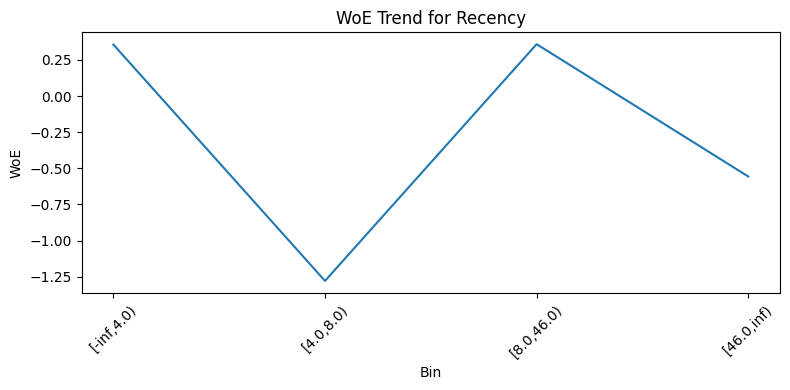

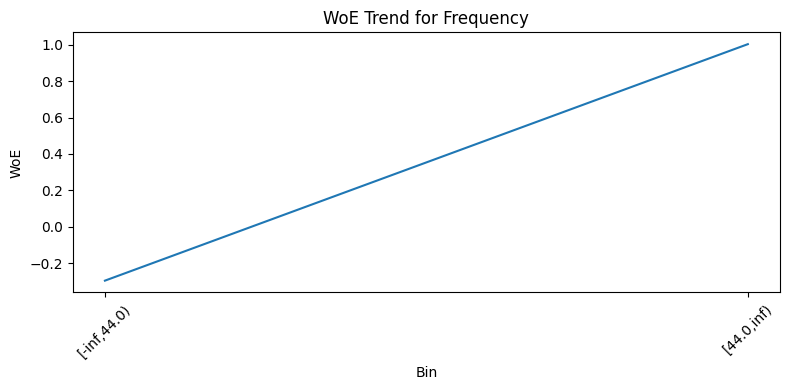

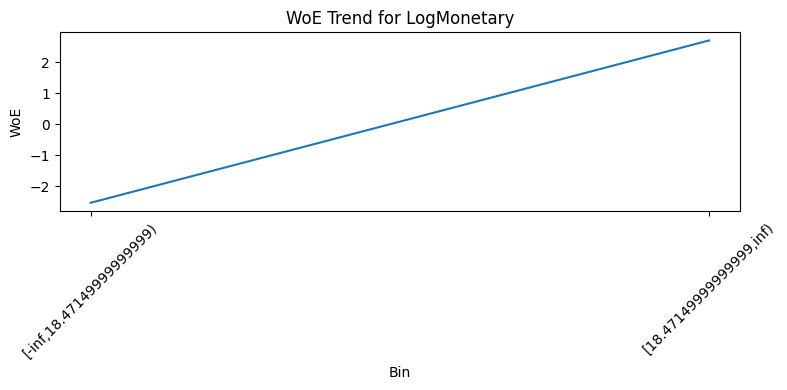

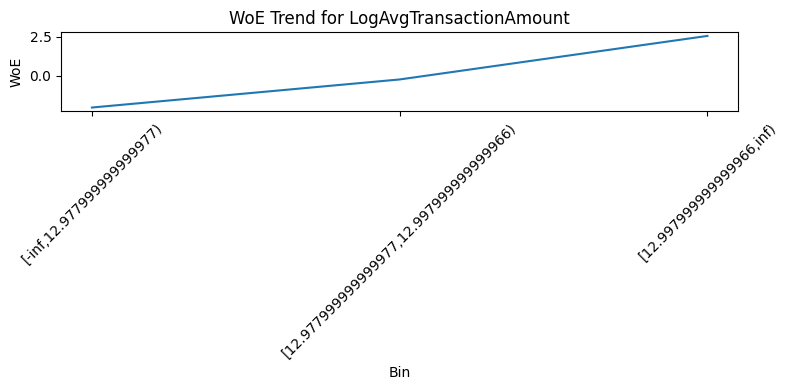

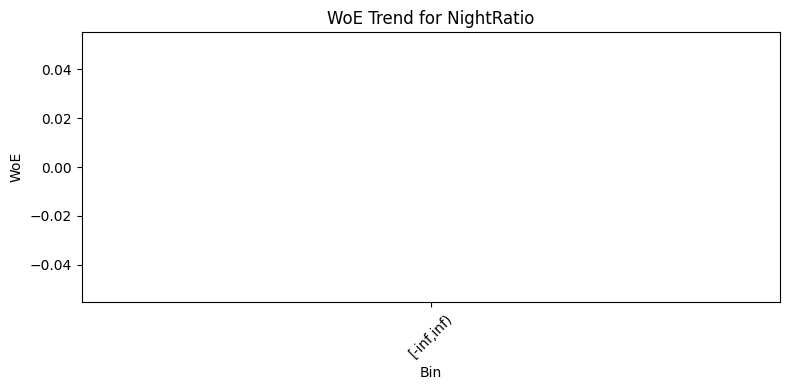

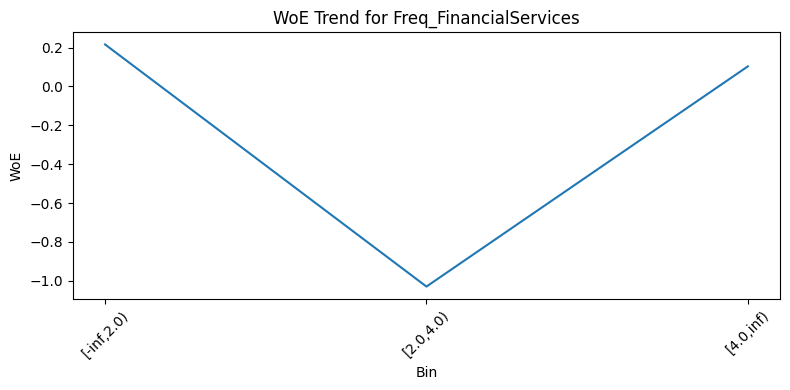

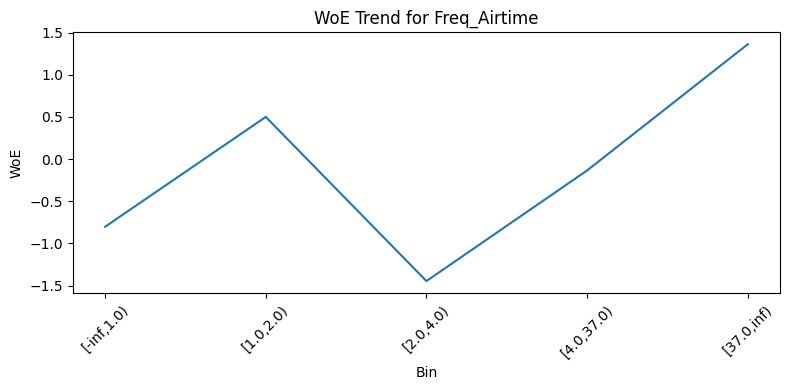

IV Scores:


,Feature,IV,PredictivePower
0,Recency,0.283670,Medium
1,Frequency,0.289246,Medium
2,LogMonetary,4.538048,Very Strong
3,LogAvgTransactionAmount,3.511328,Very Strong
4,NightRatio,0.000000,NaN
5,Freq_FinancialServices,0.160779,Medium
6,Freq_Airtime,0.652102,Very Strong


In [5]:
# Calculate WoE and IV
# Add FraudResult (1 if any transaction is fraudulent)
fraud = df.groupby('CustomerId')['FraudResult'].max().reset_index()
fraud['FraudResult'] = fraud['FraudResult'].astype(int)
# Ensure all CustomerIds in features are preserved with left merge, avoid duplicate columns
features = features.drop(columns=['FraudResult'], errors='ignore')  # Drop existing FraudResult if present
features = features.merge(fraud, on='CustomerId', how='left')
# Fill missing FraudResult values with 0 (assuming no fraud if no match)
features['FraudResult'] = features['FraudResult'].fillna(0).astype(int)

# Debug: Verify FraudResult is in features
print('FraudResult in features:', 'FraudResult' in features.columns)
print('Sample features with FraudResult:')
display(features[['CustomerId', 'FraudResult']].head())

# Features to analyze
features_to_analyze = ['Recency', 'Frequency', 'LogMonetary', 'LogAvgTransactionAmount', 'NightRatio', 'Freq_FinancialServices', 'Freq_Airtime']

# Ensure numeric dtypes to avoid unhashable type error
for col in features_to_analyze:
    features[col] = features[col].astype(float)

# Debug: Check dtypes and sample values
print('Feature dtypes:')
display(features[features_to_analyze].dtypes)
print('Sample feature values:')
display(features[features_to_analyze].head())

# Calculate WoE and IV
woe_bins = sc.woebin(features, y='FraudResult', x=features_to_analyze, method='chimerge', bin_num=10, min_bin_pct=0.05)

# Debug: Inspect bins DataFrame
print('Bins DataFrame dtypes:')
for var in woe_bins:
    print(f'{var} dtypes:')
    display(woe_bins[var].dtypes)
    print(f'{var} sample:')
    display(woe_bins[var].head())

# Custom WoE plots to avoid unhashable type error
for var in features_to_analyze:
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=woe_bins[var], x='bin', y='woe')
    plt.title(f'WoE Trend for {var}')
    plt.xlabel('Bin')
    plt.ylabel('WoE')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Show IV scores
iv_summary = pd.DataFrame({
    'Feature': features_to_analyze,
    'IV': [woe_bins[f]['total_iv'].iloc[0] for f in features_to_analyze]
})
iv_summary['PredictivePower'] = pd.cut(iv_summary['IV'], 
                                      bins=[0, 0.02, 0.1, 0.3, 0.5, np.inf],
                                      labels=['Useless', 'Weak', 'Medium', 'Strong', 'Very Strong'])
print('IV Scores:')
display(iv_summary)

## 6. Transform Features to WoE

**Short Description**: Prepares features for modeling. Converts features to WoE values for better predictions.

Replace original feature values with WoE values for model use. Show the transformed dataset.


In [6]:
# Transform features to WoE
# Create a copy of woe_bins to avoid modifying original
import copy
woe_bins_copy = copy.deepcopy(woe_bins)
# Convert variable column to strings to avoid unhashable type error
for var in woe_bins_copy:
    woe_bins_copy[var]['variable'] = woe_bins_copy[var]['variable'].astype(str)
features_woe = sc.woebin_ply(features, woe_bins_copy)

# Show transformed features
print('WoE-Transformed Features:')
display(features_woe.head())

[INFO] converting into woe values ...
WoE-Transformed Features:


,LogAvgTransactionAmount,FraudResult,Monetary,Freq_Airtime,Recency,NightRatio,Frequency,AvgTransactionAmount,Freq_FinancialServices,CustomerId,LogMonetary
0,12.936039,0,-10000.0,0.0,84.0,0.000000,1.0,-10000.000000,1.0,CustomerId_1,18.468423
1,12.936039,0,-10000.0,0.0,84.0,0.000000,1.0,-10000.000000,1.0,CustomerId_10,18.468423
2,12.969217,0,20000.0,3.0,90.0,0.000000,5.0,4000.000000,2.0,CustomerId_1001,18.468709
3,12.960752,0,4225.0,6.0,26.0,0.181818,11.0,384.090909,5.0,CustomerId_1002,18.468558
4,12.967662,0,20000.0,3.0,12.0,0.000000,6.0,3333.333333,3.0,CustomerId_1003,18.468709


## 7. Save Features

**Short Description**: Saves features for later use. Stores data for Task 4 and modeling.

Save all features (original and WoE-transformed) to `data/processed/customer_features.csv` for Task 4 and modeling.


In [7]:
# Save features
features_woe.to_csv('../data/processed/customer_features.csv', index=False)
print('Features saved to ../data/processed/customer_features.csv')


Features saved to ../data/processed/customer_features.csv


## 8. Key Findings

**Short Description**: Summarizes results to guide next steps. Highlights best features for Task 4.

Summarize insights from feature engineering to guide Task 4:
- RFM features show customer activity (Recency, Frequency, LogMonetary).
- Behavioral features (`NightRatio`, category counts) highlight risk patterns.
- Log transformation reduces `Monetary` and `AvgTransactionAmount` outliers.
- High-IV features (e.g., `LogMonetary`, `Frequency`) are best for proxy creation.
- Next: Use high-IV features for clustering in Task 4.
